In [2]:
# Import torch library and the other usual libraries
# Based on code by Naveen on nomidl.com

import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

c:\Users\kyoci\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# Define a data transformation to convert digit images to tensors
transform = transforms.ToTensor()
# Load the MNIST datasets for training and validation
# images are 28x28 pixel images of handwritten digits in a greyscale
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
valid_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create a data loader for training data with a batch size of 100
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=100)
valid_dl = torch.utils.data.DataLoader(valid_dataset, batch_size=100)

In [4]:
# Define the Encoder class for the autoencode
# Input is 28x28, one for each pixel
# Two hidden layers, one with 128 nodes, one with 16
# Latent layer has only 2 nodes! 
# Reduce dimensionality from 784 to 2!
# Layers are linear (fully connected layers with ReLU activation functions)

class Encoder(nn.Module):
    def __init__(self, input_size=28 * 28, hidden_size1=128, hidden_size2=16, z_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, z_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# Define the Decoder class for the Variational Autoencoder (VAE)
# Input is 28x28, one for each pixel
# Two hidden layers, one with 128 nodes, one with 16
# Latent layer has only 2 nodes! 
# Reduce dimensionality from 784 to 2!
# Layers are linear (fully connected layers with ReLU activation functions)

class Decoder(nn.Module):
    def __init__(self, output_size=28 * 28, hidden_size1=128, hidden_size2=16, z_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_size2)
        self.fc2 = nn.Linear(hidden_size2, hidden_size1)
        self.fc3 = nn.Linear(hidden_size1, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [6]:
# Check for GPU availability and set the device accordingly
# I don't have a GPU, so device will be 'cpu'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# Initialize the Encoder and Decoder on the selected device (i.e., 'cpu')
enc = Encoder().to(device)
dec = Decoder().to(device)

In [8]:
# Define the loss function (Mean Squared Error) 
# This will be used to compare input to the Encoder with output from the Decoder
loss_fn = nn.MSELoss()

# Select the Adam adaptive gradient descent opitmizer for both Encoder and Decoder
optimizer_enc = torch.optim.Adam(enc.parameters())
optimizer_dec = torch.optim.Adam(dec.parameters())

In [9]:
# We will run for 100 training epochs
# store the result from the loss function calculation for each epoch in train_loss[]
train_loss = []
num_epochs = 100

In [10]:
# Note that the training only uses the images
# It does not use the image labels (0,....,9)
# Loop through training epochs
for epoch in range(num_epochs):
    train_epoch_loss = 0
    if(epoch % 10 == 0):
        print("Epoch ",epoch)
    # Iterate through batches of training data
    for (imgs, _) in valid_dl:

# select and flatten the images (28x28 -> 784)
        imgs = imgs.to(device)
        imgs = imgs.flatten(1)
# encode the images to the latent layer
        latents = enc(imgs)
# decode the images to the output layer
        output = dec(latents)
# calculate the loss function
        loss = loss_fn(output, imgs)
# improve Encoder and Decoder weights for this training step
        train_epoch_loss += loss.cpu().detach().numpy()
        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()
        loss.backward()
        optimizer_enc.step()
        optimizer_dec.step()
# done with training step
# store loss for plotting
    train_loss.append(train_epoch_loss)

Epoch  0
Epoch  10
Epoch  20
Epoch  30
Epoch  40
Epoch  50
Epoch  60
Epoch  70
Epoch  80
Epoch  90
Epoch  100
Epoch  110
Epoch  120
Epoch  130
Epoch  140
Epoch  150
Epoch  160
Epoch  170
Epoch  180
Epoch  190


In [16]:
# total_loss = train_loss[-1]
# print(f"Total loss after 100 epochs: {total_loss}")
train_loss[-1]

21.217940079048276

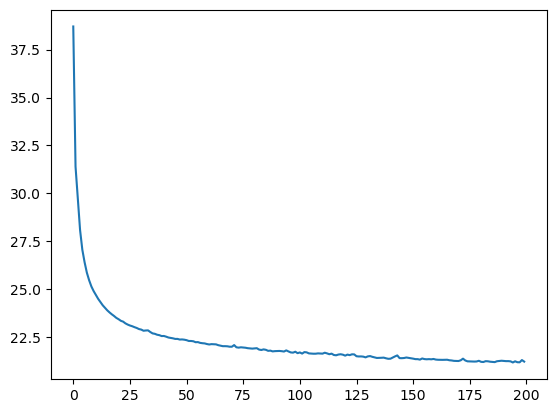

In [12]:
# Plot the training loss over epochs
plt.plot(train_loss)

In [13]:
# Let's have a look now how the images are encoded in the 2D latent space
# Each of the 28x28 images is encoded as one point in the 2D latent space

values = None
all_labels = []

# Generate latent representations for the entire training dataset
# switch off autograd; do not calculate gradients

with torch.no_grad():
    for (imgs, labels) in train_dl:

# send images to device
        imgs = imgs.to(device)
# flatten them
        imgs = imgs.flatten(1)
        all_labels.extend(list(labels.numpy()))
# encode image
        latents = enc(imgs)
        
# store values from latent layer
        if values is None:
            values = latents.cpu()
        else:
            values = torch.vstack([values, latents.cpu()])
# translate values to a numpy array
values = values.numpy()